In [1]:
import os 
os.chdir('../../')
print("Current working directory is now: ", os.getcwd())

import pandas as pd 
import numpy as np 
from IPython.display import display
import matplotlib.pyplot as plt 

from utils.load_settings import load_settings
from utils.plot_fairness import prob_recid_conditioned_sensitive_attr

%matplotlib inline
# load parameters
settings = load_settings()

Current working directory is now:  C:\Users\Caroline Wang\OneDrive\Duke\Criminal Recidivism\psa-analysis


#### Read in data 



In [3]:
kentucky_data = pd.read_csv("kentucky/data/processed/kentucky_data.csv")

for decoder_name, decoder_dict in settings['decoders'].items():
    kentucky_data = kentucky_data.replace({decoder_name: decoder_dict})

kentucky_data.rename(columns=settings['decoders']['label'], inplace=True)

### Compute group balance 

In [5]:
## kentucky
kentucky_attrs = kentucky_data[['person_id', 'screening_date', 'sex', 'race']]

kentucky_attrs = (pd.melt(kentucky_attrs, id_vars =['person_id', 'screening_date'], value_vars=['sex', 'race'])
                .rename({'variable': 'Attribute',
                         'value': 'Attribute Value'},
                        axis=1))

kentucky_attrs = kentucky_attrs.groupby(["Attribute", "Attribute Value"]).size().to_frame('n_inds').reset_index()

# check totals are same for race and sex
assert (kentucky_attrs[kentucky_attrs['Attribute']=='race']['n_inds'].sum()) == (kentucky_attrs[kentucky_attrs['Attribute']=='sex']['n_inds'].sum())
total_inds = kentucky_attrs[kentucky_attrs['Attribute']=='race']['n_inds'].sum()

# add percent col
kentucky_attrs["% total"] = ((kentucky_attrs['n_inds'] / total_inds) * 100).apply(lambda x: round(x, 2))
kentucky_attrs

Attribute   Attribute Value  n_inds  % total
0      race  African-American   25367    17.37
1      race         Caucasian  117627    80.56
2      race             Other    3009     2.06
3       sex            female   44658    30.59
4       sex              male  101345    69.41

In [6]:
## write result
kentucky_attrs.to_csv("kentucky/logs/fairness_results/data_visualizations/kentucky_racial_distr.csv")

### Check for recidivism balance across all groups for all problems

i.e. $P(Y = 1 | group = g_1)$

In [11]:
total_inds = kentucky_data.shape[0]
# unpivot the sensitive attributes
kentucky_attrs = (pd.melt(kentucky_data, id_vars =['person_id', 'screening_date'], value_vars=['sex', 'race'])
                   .rename({'variable': 'Attribute',
                            'value': 'Attribute Value'},
                            axis=1)
                    # concatenate the label info 
                   .merge(kentucky_data[['person_id', 'screening_date'] + settings["labels"]], 
                          on = ['person_id', 'screening_date'],
                          how = 'left'))

kentucky_recid_balance_groups = {}
for label in settings['labels']:
    kentucky_attrs_label = kentucky_attrs[['person_id', 'screening_date', 'Attribute', 'Attribute Value'] + [label]]

    res = (kentucky_attrs_label.groupby(['Attribute', 'Attribute Value'])
                              .sum()[label]
                              .to_frame('n_inds_recid')
                              .reset_index())
    
    res['total_inds'] = total_inds
    total_inds_with_attr = (kentucky_attrs_label
                           .groupby(['Attribute', 'Attribute Value'])
                           .size()
                           .to_frame("total_inds_with_attr")
                           .reset_index())
    
    res = res.merge(total_inds_with_attr, on = ['Attribute', 'Attribute Value'], how='left')
    res['P(Y = 1 | Attr = attr)'] = res['n_inds_recid']/res['total_inds_with_attr']
    res['P(Y = 1,  Attr = attr)'] = res['n_inds_recid']/total_inds
    res['label'] = label
    
    res.set_index('label')
    kentucky_recid_balance_groups[label] = res

In [12]:
# merge dictionary into 1 df
kentucky_recid_balance_df = (pd.concat(kentucky_recid_balance_groups, axis=0)
                            .reset_index()
                            .iloc[:, 2:])[['label', 'Attribute', 'Attribute Value', 'P(Y = 1 | Attr = attr)']]
kentucky_recid_balance_df.head()

label Attribute   Attribute Value  P(Y = 1 | Attr = attr)
0  general_two_year      race  African-American                0.280404
1  general_two_year      race         Caucasian                0.274920
2  general_two_year      race             Other                0.110336
3  general_two_year       sex            female                0.248130
4  general_two_year       sex              male                0.283211

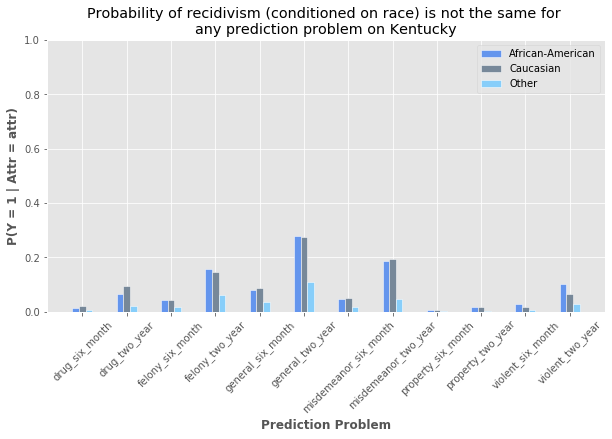

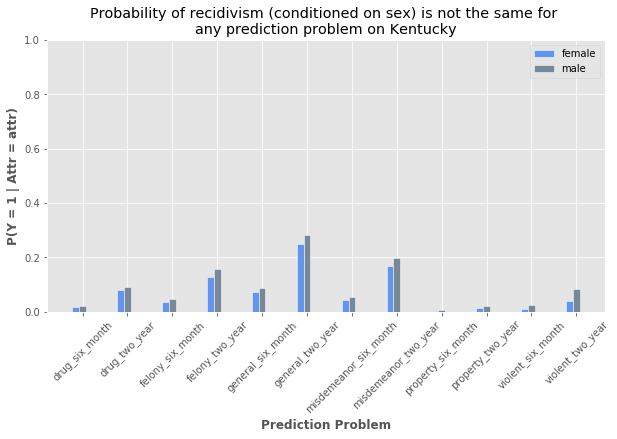

In [13]:
prob_recid_conditioned_sensitive_attr(kentucky_recid_balance_df, 
                                      "race", 
                                      dataset_name = "Kentucky",
                                      save_path = "kentucky/logs/fairness_results/data_visualizations/kentucky_prob_recid_conditioned_race.pdf")

prob_recid_conditioned_sensitive_attr(kentucky_recid_balance_df, 
                                      "sex", 
                                      dataset_name = "Kentucky",
                                      save_path = "kentucky/logs/fairness_results/data_visualizations/kentucky_prob_recid_conditioned_sex.pdf")